In [187]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [74]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

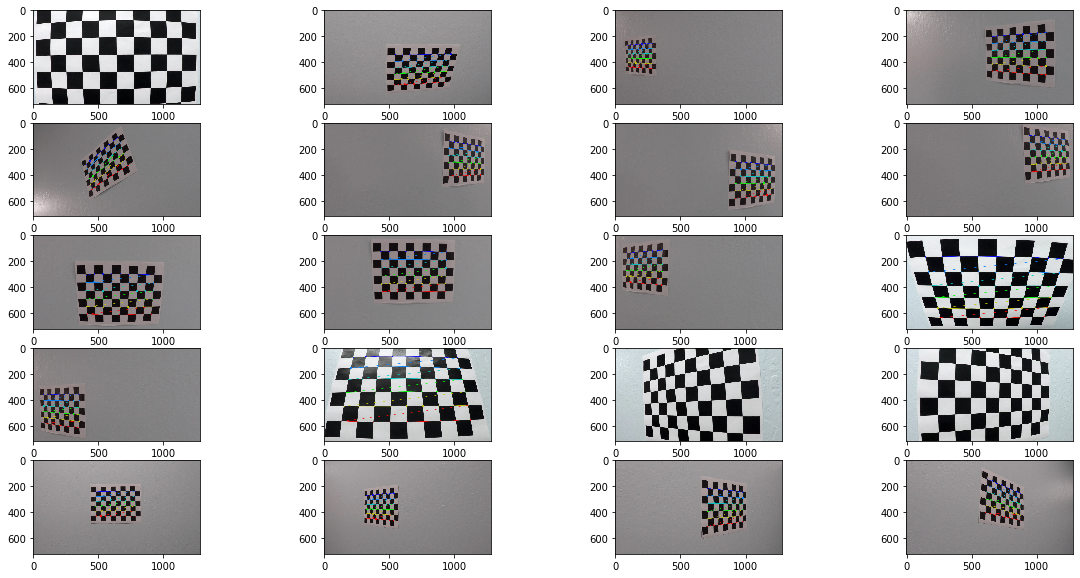

In [40]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
fig=plt.figure(figsize=(20,10))
i=0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    plt.subplot(5, 4, i+1)
    plt.imshow(img)
    i+=1

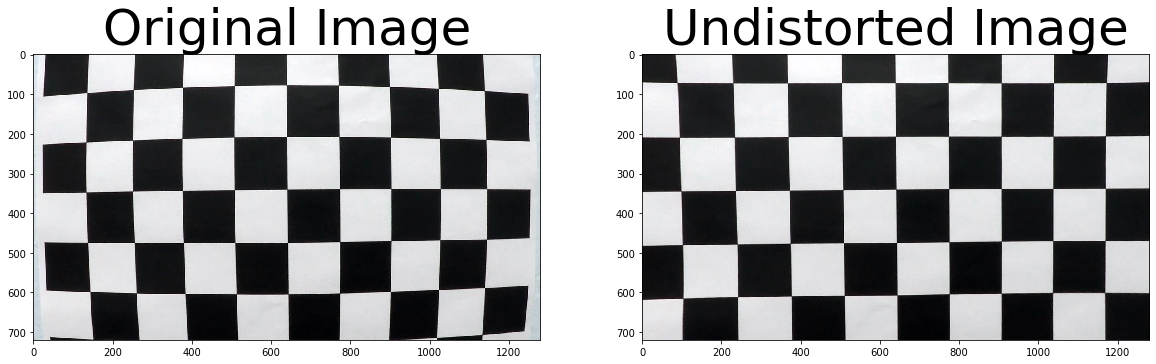

In [61]:
# Now let's test calibration
img = cv2.imread('./camera_cal/calibration1.jpg')

# Camera calibration, given object points, image points, and the shape of the grayscale image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

#Undistorting a test image:
dst = cv2.undistort(img, mtx, dist, None, mtx)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Undistorted Image', fontsize=50)
plt.imshow(dst)
plt.savefig('output_images/undistort_output.png',dpi=100);

# Pipeline (single images)

## Step 1: Provide an example of a distortion-corrected image.

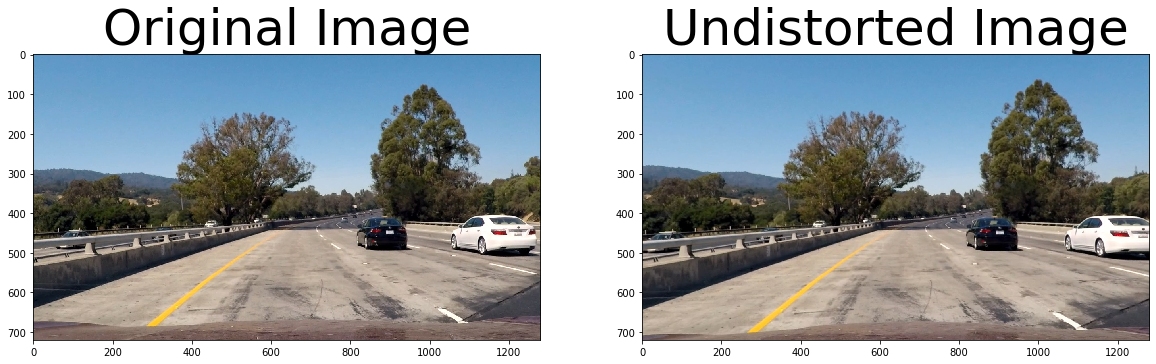

In [92]:
def undistort(img, objpoints, imgpoints):
    # Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    #Undistorting a test image:
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

    
# Now let's test calibration on a real image
img = mpimg.imread('./test_images/test1.jpg')
dst = undistort(img, objpoints, imgpoints)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Undistorted Image', fontsize=50)
plt.imshow(dst)
plt.savefig('output_images/undistort_test1.png',dpi=100);

## Step 2: Use color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

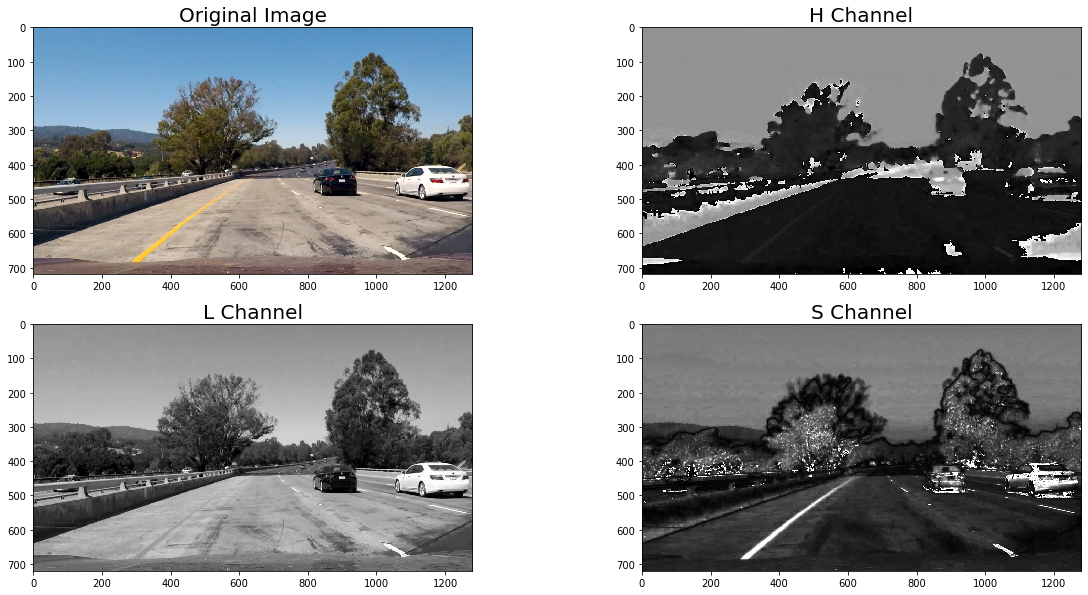

In [110]:
img = mpimg.imread('./test_images/test1.jpg')
fig=plt.figure(figsize=(20,10))
fig.tight_layout()
fig.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.subplot(2, 2, 1)
plt.title('Original Image', fontsize=20)
plt.imshow(img)
titles = ['H Channel','L Channel','S Channel']
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
for i in range(3):
    ch = hls[:,:,i]
    plt.subplot(2, 2, i+2)
    plt.title(titles[i], fontsize=20)
    plt.imshow(ch, cmap='gray')
    
plt.savefig('output_images/HLScolorchannels_test1.png',dpi=100);

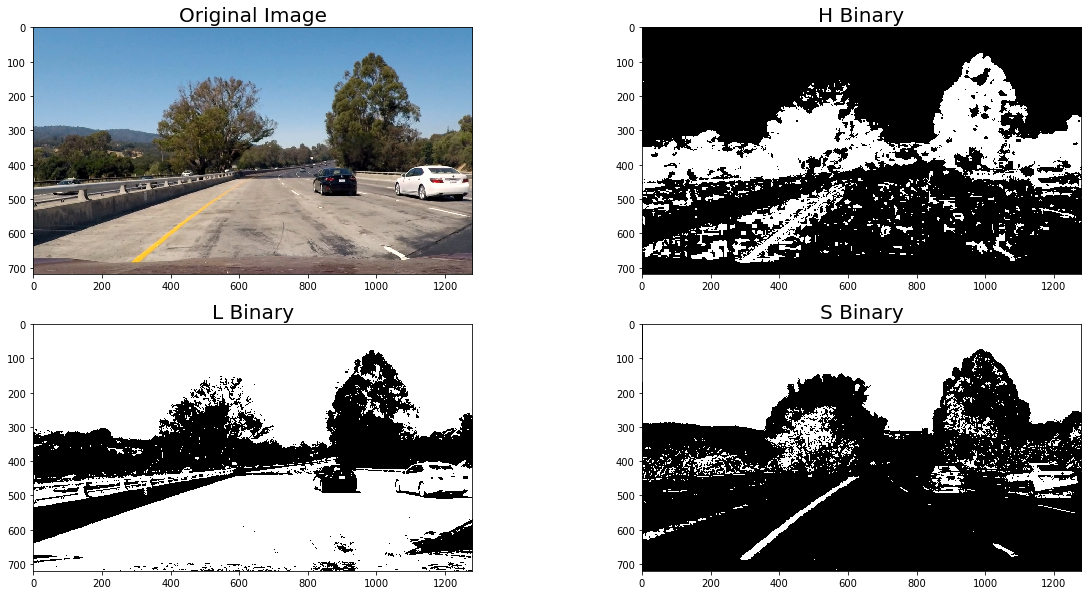

In [111]:
img = mpimg.imread('./test_images/test1.jpg')

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
fig.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.subplot(2, 2, 1)
plt.title('Original Image', fontsize=20)
plt.imshow(img)
titles = ['H Binary','L Binary','S Binary']
thresh = [(15, 100),(90, 255),(90, 255)]
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
for i in range(3):
    ch = hls[:,:,i]
    binary = np.zeros_like(ch)
    binary[(ch > thresh[i][0]) & (ch <= thresh[i][1])] = 1
    plt.subplot(2, 2, i+2)
    plt.title(titles[i], fontsize=20)
    plt.imshow(binary, cmap='gray')
    
plt.savefig('output_images/HLScolorthresholds_test1.png',dpi=100);

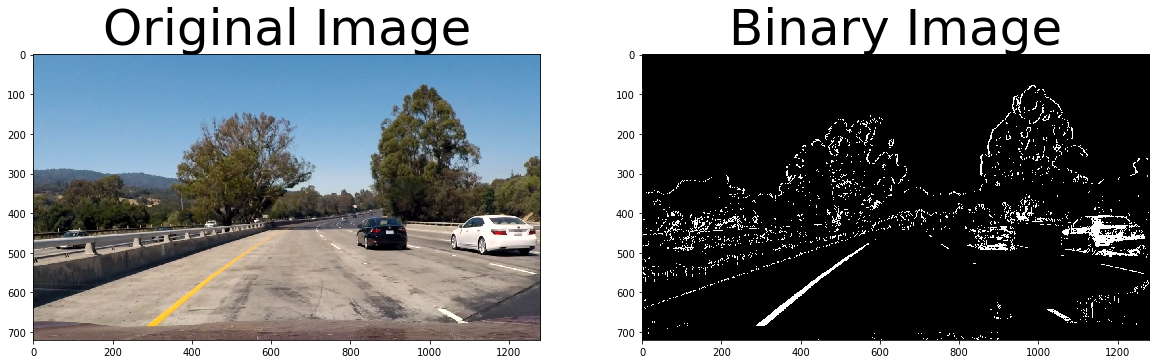

In [134]:
def createBinary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(h_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(sxbinary)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Now combine both
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Now let's test it on a real image
img = mpimg.imread('./test_images/test1.jpg')
dst = createBinary(img)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Binary Image', fontsize=50)
plt.imshow(dst, cmap='gray')
plt.savefig('output_images/binary_test1.png',dpi=100);

# Step 3: Perform a perspective transform and provide an example of a transformed image

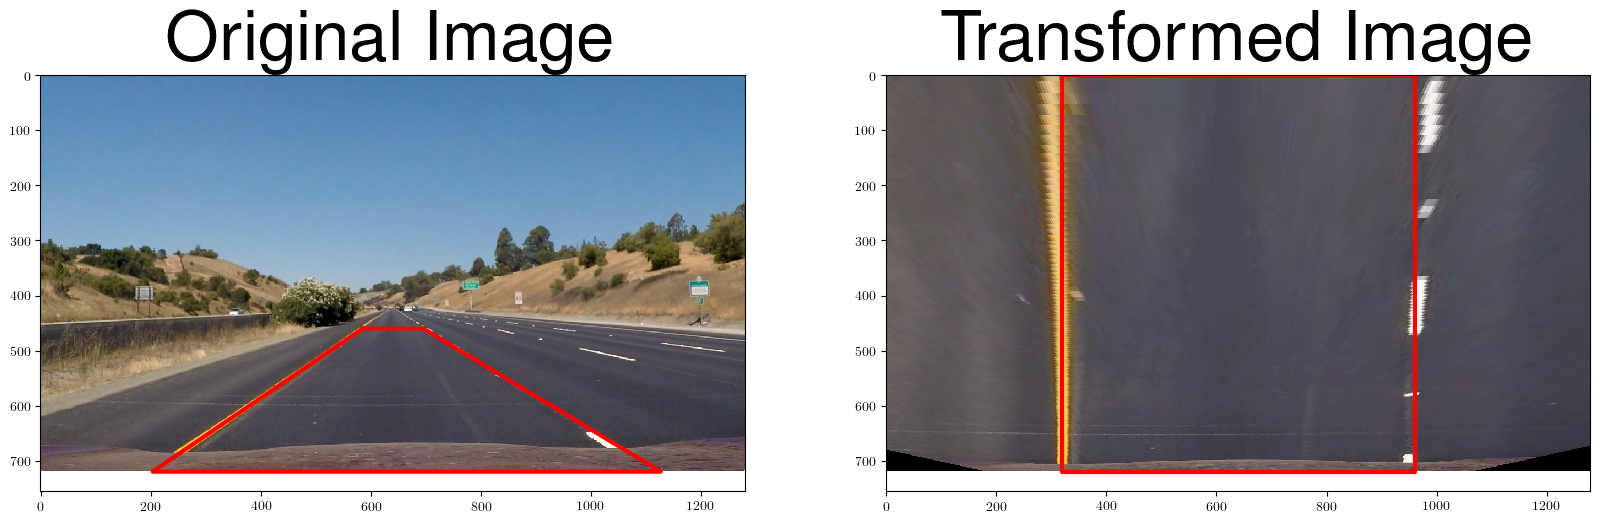

In [245]:
def warper(img):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped, src, dst, M, Minv

# Now let's test it on a real image
img = mpimg.imread('./test_images/straight_lines1.jpg')
warped, src, dst, M, Minv = warper(img)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.plot([i[0] for i in src]+[src[0][0]],[i[1] for i in src]+[src[0][1]], color='red',linewidth=3)
plt.subplot(1, 2, 2)
plt.title('Transformed Image', fontsize=50)
plt.imshow(warped, cmap='gray')
plt.plot([i[0] for i in dst]+[dst[0][0]],[i[1] for i in dst]+[dst[0][1]], color='red',linewidth=3)
plt.savefig('output_images/warp_test1.png',dpi=100);

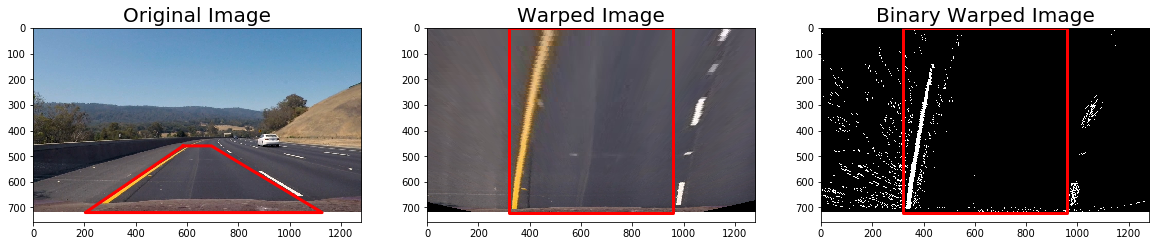

In [143]:
# Load our image
img = mpimg.imread('./test_images/test3.jpg')
warped, src, dst = warper(img)
binary_warped = createBinary(warped)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 3, 1)
plt.title('Original Image', fontsize=20)
plt.imshow(img)
plt.plot([i[0] for i in src]+[src[0][0]],[i[1] for i in src]+[src[0][1]], color='red',linewidth=3)
plt.subplot(1, 3, 2)
plt.title('Warped Image', fontsize=20)
plt.imshow(warped, cmap='gray')
plt.plot([i[0] for i in dst]+[dst[0][0]],[i[1] for i in dst]+[dst[0][1]], color='red',linewidth=3)
plt.subplot(1, 3, 3)
plt.title('Binary Warped Image', fontsize=20)
plt.imshow(binary_warped, cmap='gray')
plt.plot([i[0] for i in dst]+[dst[0][0]],[i[1] for i in dst]+[dst[0][1]], color='red',linewidth=3)

plt.savefig('output_images/binary_warped_test3.png',dpi=100);

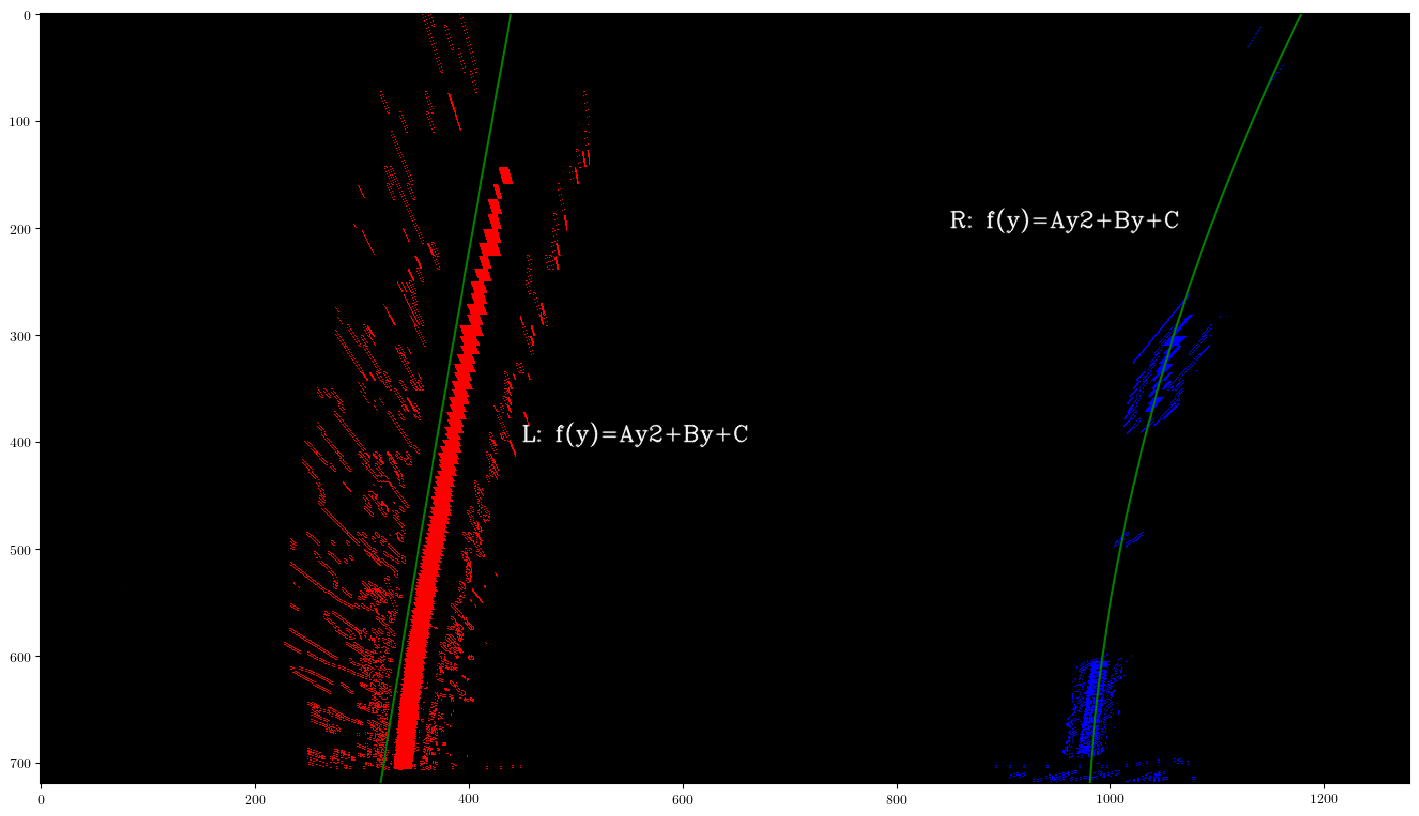

In [243]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]


    
    #cv2.putText(out_img, text)
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(binary_warped)
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='green')
plt.plot(right_fitx, ploty, color='green')

# textl = r'$f_\{right\}\(y\)=A_\{right\}y^2+B_\{right\}y+C_\{right\}$'
cv2.putText(out_img, 'L: f(y)=Ay2+By+C',
                (450,400),cv2.FONT_HERSHEY_COMPLEX,.7,(255,255,255),0,cv2.LINE_AA)
cv2.putText(out_img, 'R: f(y)=Ay2+By+C',
                (850,200),cv2.FONT_HERSHEY_COMPLEX,.7,(255,255,255),0,cv2.LINE_AA)

plt.imshow(out_img)
plt.savefig('output_images/fitted_test3.png',dpi=100);

# Step 5: Calculate the radius of curvature of the lane and the position of the vehicle with respect to center

In [244]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr, center_img):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    ##### Calculate the distance between center of image and center of lane
    left_x = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_x = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    center_x = (left_x + right_x)//2
    dist_m = xm_per_pix * (center_x - center_img)
    
    return left_curverad, right_curverad, np.round(dist_m,3)

out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(binary_warped)

left_curverad, right_curverad , dist_m = measure_curvature_real(ploty, left_fit, right_fit, out_img.shape[1]//2)

FinalText = "Radius of Curvature = "+str(min(int(left_curverad),int(right_curverad)))+'(m)\n'
if dist_m>0: FinalText+="vehicle is "+str(np.absolute(dist_m))+'m left of center'
elif dist_m <0: FinalText+="vehicle is "+str(np.absolute(dist_m))+'m right of center' 
else: FinalText+="vehicle is at the center"
print(FinalText)

Radius of Curvature = 2311(m)
vehicle is 0.048m left of center


## Step 6: Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

In [273]:
def getX(fit,y):
    return fit[0]*y**2 + fit[1]*y + fit[2]
print(getX(left_fit,np.max(ploty)),np.max(ploty))

317.4358827329962 719.0


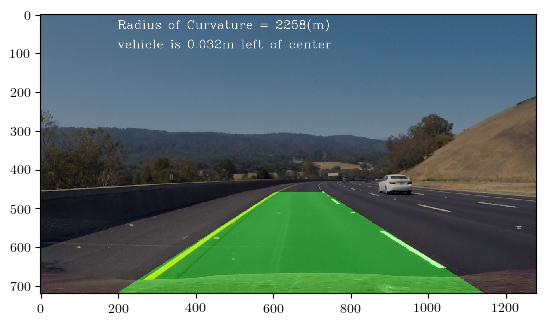

In [316]:
def pipeline(img, objpoints, imgpoints):
    # Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    warped, src, dst, M, Minv = warper(undistorted)
    
    binary_warped = createBinary(warped)
    
    out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(binary_warped)

    left_curverad, right_curverad , dist_m = measure_curvature_real(ploty, left_fit, right_fit, out_img.shape[1]//2)
    
    ## Draw and fill the green polygon
    ### Calculate the unwarped counterpart of the two fits
    y_max = np.max(ploty)#src[1,1]
    y_min = np.min(ploty)#src[0,1]
    fitpoly = np.float32(
        [[getX(left_fit,y_max),y_max],
         [getX(left_fit,y_min),y_min],
         [getX(right_fit,y_min),y_min],
         [getX(right_fit,y_max),y_max]])
    
    polylay = np.zeros_like(warped)
    cv2.fillPoly(polylay, np.array([fitpoly], dtype=np.int32), (0,100,0),lineType=8, shift=0)
    #masked_warped = cv2.bitwise_and(warped, polylay)
    #warped = cv2.addWeighted(warped, 0.7, polylay, 1., 0.)
    unwarped_polylay = cv2.warpPerspective(polylay, Minv, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_NEAREST)
    output_img = cv2.addWeighted(img, 0.7, unwarped_polylay, 1., 0.)
    
    
    FinalText1 = "Radius of Curvature = "+str(min(int(left_curverad),int(right_curverad)))+'(m)'
    if dist_m>0: FinalText2="vehicle is "+str(np.absolute(dist_m))+'m left of center'
    elif dist_m <0: FinalText2="vehicle is "+str(np.absolute(dist_m))+'m right of center' 
    else: FinalText2="vehicle is at the center"
    
    cv2.putText(output_img, FinalText1,(200,40),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),0,cv2.LINE_AA)
    cv2.putText(output_img, FinalText2,(200,90),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),0,cv2.LINE_AA)    
    return output_img#, FinalText

img = mpimg.imread('./test_images/test3.jpg')
output_img = pipeline(img, objpoints, imgpoints)
plt.imshow(output_img)
plt.savefig('output_images/pipeline_test3.png',dpi=100);

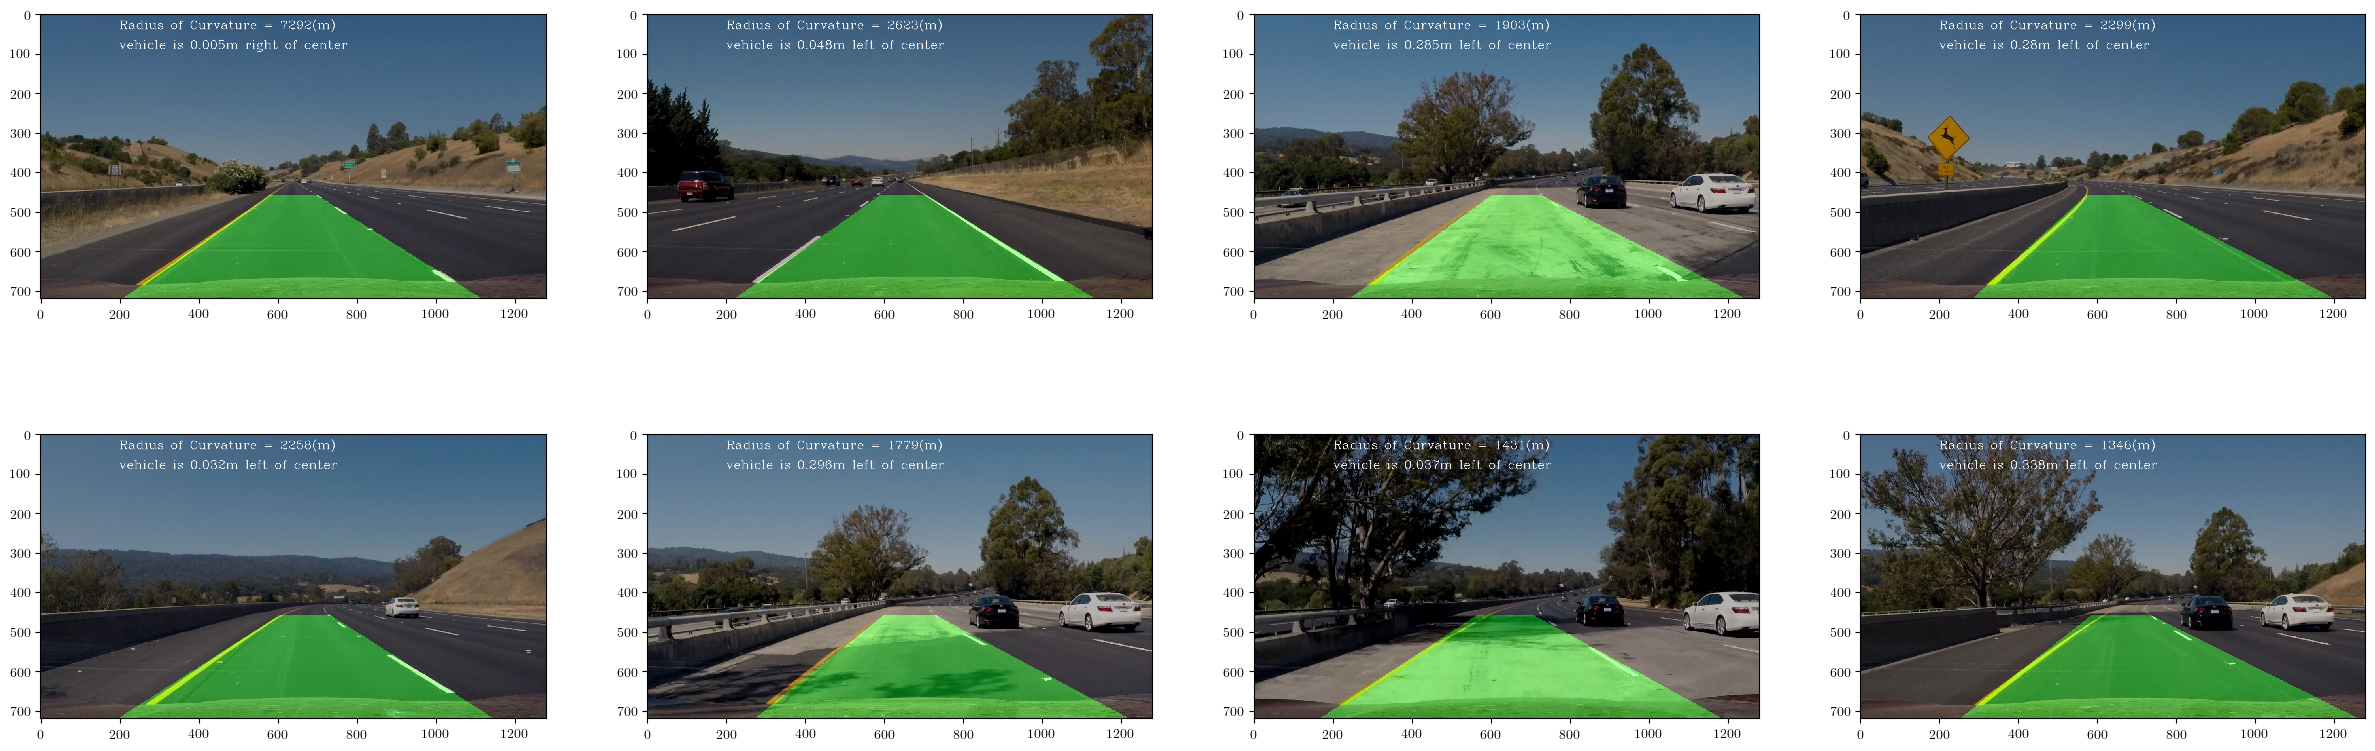

In [315]:
folder = './test_images/'
imgNames = os.listdir(folder)
fig=plt.figure(figsize=(30,10))
for i in range(len(imgNames)):
    plt.subplot(2, 4, i+1)
    image = mpimg.imread(folder+imgNames[i])
    output_img = pipeline(image, objpoints, imgpoints)
    plt.imshow(output_img)
    #plt.imsave('output_images/'+imgNames[i]+'_output.png', output_img)

In [275]:
src

array([[ 585.     ,  460.     ],
       [ 203.33333,  720.     ],
       [1126.6666 ,  720.     ],
       [ 695.     ,  460.     ]], dtype=float32)

In [277]:
src[1,1]

720.0

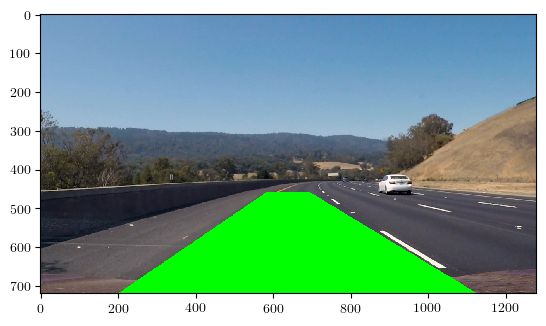

In [269]:
#cv2.FillPoly(img, src, 'green', lineType=8, shift=0)
#mask = np.zeros_like(img)
cv2.fillPoly(img, np.array([src], dtype=np.int32), (0,255,0))#,lineType=8, shift=0)
#masked_image = cv2.bitwise_and(img, mask)
plt.imshow(img)